In [0]:
!pip install scikit-plot

In [0]:
import numpy as np
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
import os
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
from nltk.corpus import stopwords
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

In [0]:
def clean_data():
    """
    Generate processed string
    """
    path = 'train.csv'
    vector_dimension=300

    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = clean_up_text(data.loc[i,'text'])

    data = data.sample(frac=1).reset_index(drop=True)

    x = data.loc[:,'text'].values
    y = data.loc[:,'label'].values

    train_size = int(0.8 * len(y))
    test_size = len(x) - train_size

    xtr = x[:train_size]
    xte = x[train_size:]
    ytr = y[:train_size]
    yte = y[train_size:]

    np.save('xtr_shuffled.npy',xtr)
    np.save('xte_shuffled.npy',xte)
    np.save('ytr_shuffled.npy',ytr)
    np.save('yte_shuffled.npy',yte)

In [0]:
def remove_stop_words(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)

In [0]:
def clean_up_text(text):
#    text = remove_stop_words(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

In [0]:
def construct_labeled_sentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [0]:
def get_word_embeddings(path,vector_dimension=300):
    data = pd.read_csv(path,engine="python")

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = clean_up_text(data.loc[i,'text'])

    x = construct_labeled_sentences(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.epochs)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    xtrain = np.zeros((train_size, vector_dimension))
    xtest = np.zeros((test_size, vector_dimension))
    ytrain = np.zeros(train_size)
    ytest = np.zeros(test_size)

    for i in range(train_size):
        xtrain[i] = text_model.docvecs['Text_' + str(i)]
        ytrain[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        xtest[j] = text_model.docvecs['Text_' + str(i)]
        ytest[j] = y[i]
        j = j + 1

    return xtrain, xtest, ytrain, ytest

In [0]:
def clean_data():
    """
    Generate processed string
    """
    path = 'train.csv'
    vector_dimension=300

    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = clean_up_text(data.loc[i,'text'])

    data = data.sample(frac=1).reset_index(drop=True)

    x = data.loc[:,'text'].values
    y = data.loc[:,'label'].values

    train_size = int(0.8 * len(y))
    test_size = len(x) - train_size

    xtr = x[:train_size]
    xte = x[train_size:]
    ytr = y[:train_size]
    yte = y[train_size:]

    np.save('xtr_shuffled.npy',xtr)
    np.save('xte_shuffled.npy',xte)
    np.save('ytr_shuffled.npy',ytr)
    np.save('yte_shuffled.npy',yte)

In [0]:
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred,normalize=False)
    plt.show()

Naive Bayes Accuracy = 85.26%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


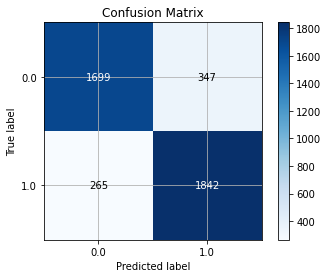

In [0]:
import csv
csv.field_size_limit(500 * 1024 * 1024)
if not (os.path.isfile('./xtr.npy') and os.path.isfile('./xte.npy') and os.path.isfile('./ytr.npy') and os.path.isfile('./yte.npy')):
    xtr,xte,ytr,yte = get_word_embeddings('train.csv')
    np.save('./xtr', xtr)
    np.save('./xte', xte)
    np.save('./ytr', ytr)
    np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

bnb = BernoulliNB()
bnb.fit(xtr,ytr)
y_pred = bnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Naive Bayes Accuracy = " + format((m-n)/m*100, '.2f') + "%")

# Draw the confusion matrix
plot_cmat(yte, y_pred)

SVM Accuracy = 93.43%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


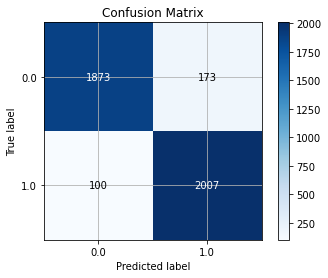

In [0]:
clf = LinearSVC ()
clf.fit(xtr, ytr)
y_pred = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("SVM Accuracy = " + format((m-n)/m*100, '.2f') + "%")

# Draw the confusion matrix
plot_cmat(yte, y_pred)

Accuracy = 76.52%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


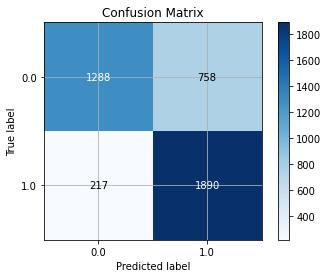

In [0]:
from sklearn.naive_bayes import GaussianNB
# Use the built-in Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(xtr,ytr)
y_pred = gnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 72.94%

# Draw the confusion matrix
plot_cmat(yte, y_pred)

Accuracy = 56.42%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


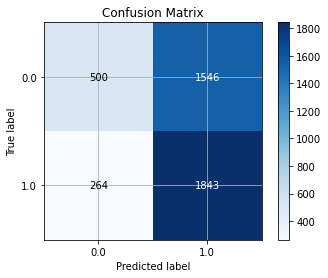

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(xtr)
y_pred = kmeans.predict(xte)

m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")

# Draw the confusion matrix
plot_cmat(yte, y_pred)

Accuracy = 65.37%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


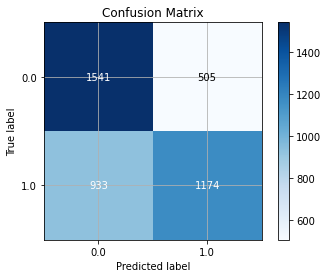

In [0]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, max_iter=10000)
gmm.fit(xtr)

y_pred = gmm.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")

# Draw the confusion matrix
plot_cmat(yte, y_pred)

In [0]:
!pip install xgboost

Accuracy = 91.16%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


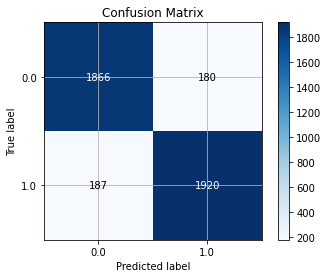

In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(xtr, ytr)

y_pred = xgb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")

# Draw the confusion matrix
plot_cmat(yte, y_pred)